In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
USE_EXTERNAL_DATASET = True

if USE_EXTERNAL_DATASET:
    data = pd.read_csv('data/stance_data.csv')
    data = data.rename(columns={'post': 'titles', 'new_topic': 'subjects', 'label': 'stances'})
    data['stances'] = data['stances'].astype('category')
    # convert from 0=con, 1=pro, 2=neutral to 0=neg, 1=neu, 2=pro
    neu = data['stances'] == 1
    data.loc[data['stances'] == 2, 'stances'] = 1
    data.loc[neu, 'stances'] = 2
else:
    data = pd.read_csv('data/RoundedLabelled.csv')
    data = data.rename(columns={'title': 'titles', 'topic': 'subjects', 'stance': 'stances'})
    data['stances'] = data['stances'].astype('category')

# data_train = data
X_train, X_test, y_train, y_test = train_test_split(data[['titles', 'subjects']], data['stances'], test_size=0.33)

pd.set_option('display.max_colwidth', None)
display(data)
print(data.dtypes)

display(X_train)

,titles,subjects,stances
0,"Regulation of corporations has been subverted by corporations. States that incorporate corporations are not equipped to regulate corporations that are rich enough to influence elections, are rich enough to muster a legal team that can bankrupt the state. Money from corporations and their principals cannot be permitted in the political process if democracy is to survive.",regulation,0
1,"Absolutely it's needs to be defined and regulated in its use, as currently the word 'natural' when used on food products is totally confusing and meaningless. Clearly they are trying to imply the item is 'healthy' or possibly 'organic', but when you see food 'manufacturers' like Frito-Lay or Campbell's with products labelled 'natural', that alone should set off alarms that all is not what it seems. ;-)",healthy,2
2,"""...one must ask how much money they must make to demonstrate that they are among the best managed companies on the planet."" They must make enough money to insure that they can never fail and threaten the stability of the worlds economy again. That much money.",the economy,0
3,"The whole media mess surrounding the royals is a consequence of the promotional fervor with which royal households (aka, public relations experts) developed stage-set performances for the public to devour. Prior to the Victorian era, those elaborate and lethally expensive weddings, coronations, and funerals - and the fairy tales that went along with them - just didn't exist.",the royals,2
4,"Violence is inherent in the sex industry only in the same way that criminality is inherent in business in Russia. All private business in Russia was illegal under communism, so when communism fell, the first and strongest entrants were people from criminal backgrounds who had already been engaging in it illegally. They have not yet lost control; not enough time has passed. Similarly, because prostitution has been illegal in many places, even where it has become legal, there is a tendency for it to initially be dominated by the sometimes violent pimps who prevailed when it was illegal. As time passes, in large areas where it is fully legal, it will become less dominated by the criminal element and less violent (although it will never cease to be unpleasant in other ways).",prostituion,2
...,...,...,...
1716,"Allowing maximum access does not cause maximum use. It distributes use over a broader set of beaches, actually reducing crowding. Further, people don't change rental-car oil because that is the contractual responsibility of the rental company. It is not akin to a commons. The shore is a commons and the public has both the right to enjoy it and he responsibility to protect it.",rental companys,2
1717,The issue is what do I have to pay for the bankers to have the privlege of using my money to make a profit. In older times they went out and made good investments. Now they just want to shake me down for every last farthing. Shame on them. They will be made to change and the sooner the better.,banker,0
1718,"I personally believe that whatever the outcome of the civil war, the one outcome which would lead to a much wider and more destructive war would be a true victory by Assad's forces which would empower Hezbollah and project Iranian power through its erstwhile clients to the shores of the Mediterranean. This is a truly regionally destabilizing possibility which would present many powers in the area with difficult potentially war causing choices. That fear draws ample support from the powers that most fear that outcome and it tends to place those resources in the hands of the most destabilizing forces in the opposition which include the most militant of islamists and those bearing the greatest ressentinent against Shiites and minority groups in Syria. The only way to stanch that flow of resources is to at least supply the most acceptable opposition forces and to marginalize the more dangerous opposition actors. What all this means is that inte

titles        object
subjects      object
stances     category
dtype: object


,titles,subjects
1651,"Even though I have to respect the reasoning to veganism, I do believe that there are definite risks involved. A diet based on plants does not provide a sufficient source of energy to the body. Without a source of protein or carbohydrate, the body tends to slow down and function slower. Facts are facts. All of them in the article stand firm. Babies need a variety of foods especially because it is critical in their development. As an adult you can make this decision for yourself, but think of your child who needs all the foods from the pyramid to grow and be the healthy individual you want them to be.",veganism
1006,"The ones who teach should be very concerned. Every time schools at any level, or education systems anywhere, or the ones who teach get tested or graded or rated somehow, it is always the teachers who get fired. Never the students. Or the parents. Or the system. THE TEACHERS. And no, I have never been a teacher or a school employee - just a student and an observer.",teacher
167,"To comment #1 above: This is only a short term cost differential (2-5 years) until the manufacturing ramps up. The Toyota Prius was also ridiculed for it's inability to be profitable when it first came out. Now it is the only car that Toyota dealers will not offer any incentive on. There will be leaders who will pay too much for electric cars of this type (remember the 15,000 LCD screens), but in a short period of time the prices will make our addiction to gas go away.",electric cars
1338,"Nope. I, a male, taught at an all girls high school in the 1970s. Then and now I realized what same sex education gives young women, and it ain't rocket science (although that certainly should be prominent in the curriculum). What these smart, no-nonsense young women learn is to EXPECT to be taken seriously, expect to compete on a equal basis with those around them, expect to get the prize when they actually win. Getting along with the boys is not the solution for the girls. It's the problem, friend, it's the problem.",same sex education
991,"The government has a right to expect some measure of a return on the billions paid to institutions in the form of federal aid. Educators should be expected to be held accountable for some minimum degree of achievement from all the federal dollars they receive. Why throw good money into institutions that have a high dropout rate. We need to force these institutions to have ""some skin in the game"" as this will force colleges to have a stake in a students outcome.",dropout rate
...,...,...
1348,"Given that Europeans have not done so well integrating the Muslim immigrants they already have (witness the suspect in Belgium, where in immigrant community the employment rate is 40 percent), why should we believe this recent wave is any more assimilable? In twenty years, will Europe create even more alienated residents who are willing to slaughter their fellow citizens?",muslim immigrants
622,"If laws like this are a good way of dealing with reality, I'll stick to reading fiction. Public schools do differentiate between students! Most schools have AP classes, gifted programs, etc. Even elementary and middle schools have talented and gifted programs and/or challenge courses. How much students care to learn also affects how much they end up learning. I'm quite confused what is good about this idea of yours as it seems to equate public education to shoe shopping. I am saddened that people are making money off these stupid ideas that you seem to be willing to propagate. Kids go to public schools and they do learn there. If parents want them to learn a competing view, have them pick up a book after school and learn some more. To ask public schools to cater to the whims of parents is more harmful than the big, bad federal government mandates you seem to fear sir.",kids
583,"Nationalizing the banks would only move them from a bureaucracy that is too big to one that is even larger. If we do nationalize them, at 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 titles (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 subjects (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['titles[0][0]',                 
                                (None, 128),                      'subjects[0][0]']               
                                 'input_mask': (Non                                               
                                e, 128),                                                      

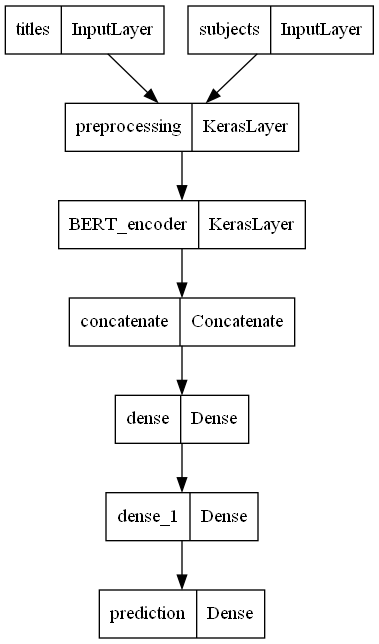

In [15]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"
hidden_layer_sizes = [300, 100]
alpha_leaky_relu = 0.01
dropout = 0
number_of_output_classes = 3

def build_classifier_model():
    # Handle categorical labels
    # encoded_stance = get_category_encoding_layer(name='categorical', dataset=data_train, dtype='string')

    # BERT embeddings
    preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')

    titles = tf.keras.layers.Input(shape=(), dtype=tf.string, name='titles')
    titles_preprocessed = preprocessor(titles)

    subjects = tf.keras.layers.Input(shape=(), dtype=tf.string, name='subjects')
    subjects_preprocessed = preprocessor(subjects)

    # pooled_output gives the embedding per input sequence, alternatively sequence_output would give it per input token
    titles_embedded = encoder(titles_preprocessed)["pooled_output"]
    subjects_embedded = encoder(subjects_preprocessed)["pooled_output"]

    # Concat features
    # titles_embedded = tf.keras.layers.Flatten()(titles_embedded)
    # subjects_embedded = tf.keras.layers.Flatten()(subjects_embedded)
    concatenated_features = tf.keras.layers.Concatenate()([titles_embedded, subjects_embedded])
    out = concatenated_features

    # Neural network hidden layers
    for number_of_hidden_units in hidden_layer_sizes:
        out = tf.keras.layers.Dense(number_of_hidden_units, activation=tf.keras.layers.LeakyReLU(alpha=alpha_leaky_relu))(out)
        if dropout > 0:
            out = tf.keras.layers.Dropout(dropout)(out)

    # Output
    out = tf.keras.layers.Dense(number_of_output_classes, activation=tf.nn.softmax, name='prediction')(out)

    return tf.keras.Model(
        inputs = [titles, subjects],
        outputs = out
    )

# In case of "SavedModel file does not exist at:" error, go the Temp\tfhub_modules folder it references and delete it
model = build_classifier_model()
model.summary()
tf.keras.utils.plot_model(model)

In [16]:
# data_train['titles']
# data_train['subjects']
# # data_train.loc['stances'] = data_train['stances'].values.astype(np.float32)
# data_train['stances']
#
# print(data.dtypes)

In [22]:
# steps_per_epoch = tf.data.experimental.cardinality(data_train).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)
#
# init_lr = 3e-5
# optimizer = tf.keras.optimizers.create_optimizer( init_lr=init_lr,
#                                                   num_train_steps=num_train_steps,
#                                                   num_warmup_steps=num_warmup_steps,
#                                                   optimizer_type='adamw')

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

epochs=5
history = model.fit(
    x=[
        X_train['titles'],
        X_train['subjects']
    ],
    y=y_train,
    epochs=epochs,
    validation_data=([X_test['titles'], X_test['subjects']], y_test)
)


Epoch 1/5
37/37 [==============================] - 267s 7s/step - loss: 0.7632 - accuracy: 0.5212 - val_loss: 0.8324 - val_accuracy: 0.4877
Epoch 2/5
37/37 [==============================] - 265s 7s/step - loss: 0.7315 - accuracy: 0.5611 - val_loss: 0.9954 - val_accuracy: 0.4577
Epoch 3/5
37/37 [==============================] - 265s 7s/step - loss: 0.7332 - accuracy: 0.5750 - val_loss: 0.7822 - val_accuracy: 0.5405
Epoch 4/5
37/37 [==============================] - 259s 7s/step - loss: 0.7125 - accuracy: 0.5681 - val_loss: 0.8468 - val_accuracy: 0.4806
Epoch 5/5
37/37 [==============================] - 266s 7s/step - loss: 0.7098 - accuracy: 0.5768 - val_loss: 0.7901 - val_accuracy: 0.5687


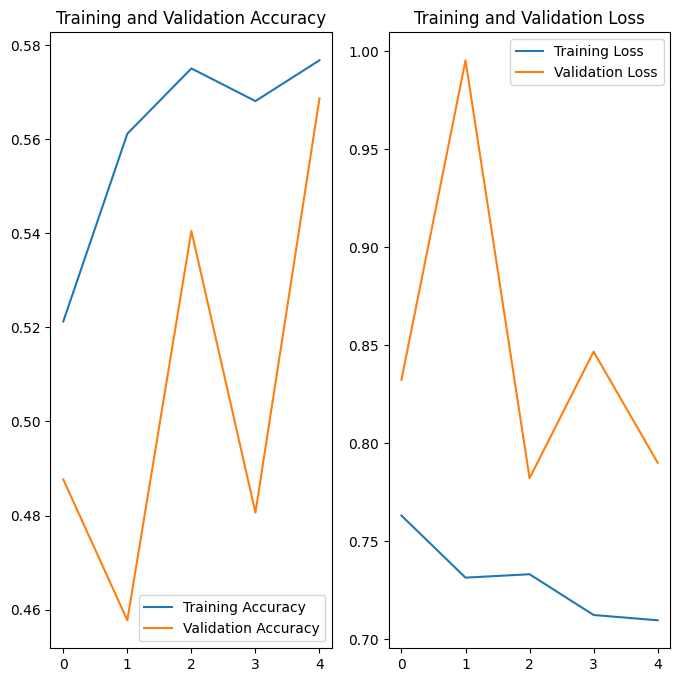

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model.save("/models/stance_model_v4")

INFO:tensorflow:Assets written to: /models/stance_model_v4\assets


INFO:tensorflow:Assets written to: /models/stance_model_v4\assets


In [ ]:
from tensorflow import keras

# load model
# model = keras.models.load_model("/models/stance_model_v1")